In [1]:
import numpy as np
import matplotlib.pyplot as plt

from models import deconvolution

# Inverse problem

In [2]:
import pickle
import scipy.stats as stats


with open('data_deconv.pkl', 'rb') as f:
    t_sens, y_data, sigma_obs, theta_true, t_true, x_true = pickle.load(f)

In [3]:
n = 251
D = [0, 1]

t = np.linspace(D[0],D[1], n)
t = np.round(t, 3)
d_k = 40

mu_u = -0.6
sigma_2_u = 0.05**2

d = t_true.shape[0]

In [4]:
import arviz as az

from models import deconvolution
from utils_plotting import plotmatrix, posterior_stats_1D, histogram


model = deconvolution(int(np.round(n/2)), int(n/20), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

# standard deviation of the noise
sigma_noise = np.std(sigma_obs)**2


In [5]:
def U(omega):
    u_t = np.zeros(len(t))
    for ii in range(len(t)):
        t_now = t[ii]
        if ((t_now>=0) and (t_now<0.25)):
            u = omega[0]
        elif ((t_now>=0.25) and (t_now<0.5)):
            u = omega[1]
        elif ((t_now>=0.5) and (t_now<0.75)):
            u = omega[2]
        elif ((t_now>=0.75) and (t_now<=1)):
            u = omega[3]
        u_t[ii] = u
    return u_t

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

bnn_prior = nn.Sequential(
    bnn.BayesLinear(prior_mu=mu_u, prior_sigma=0.05, in_features=d, out_features=1),
    nn.ReLU(),
)

In [7]:
sigma2_noise = sigma_obs**2 # sigma_obs is given in the loaded data
def log_likelihood(omega):
   return -(1/(2*sigma2_noise))*np.linalg.norm(y_data - A @ np.exp(omega))**2

#def log_prior(omega):
#    return np.log(stats.multivariate_normal.pdf(omega, mean=mu_u*np.ones(d), cov=sigma_2_u*np.eye(d)))

def log_prior(omega):
    prior_bnn = bnn_prior(torch.Tensor(omega)).detach().numpy()
    return prior_bnn


def log_target(omega):
    log_likelihood_value = log_likelihood(omega)
    log_prior_value = log_prior(omega)
    log_posterior = log_likelihood_value + log_prior_value
    return log_posterior

neg_log_post = lambda omega: -log_target(omega)

/tmp/ipykernel_5469/2240653673.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prior_realizations[ii, jj] = np.exp(log_prior(t))


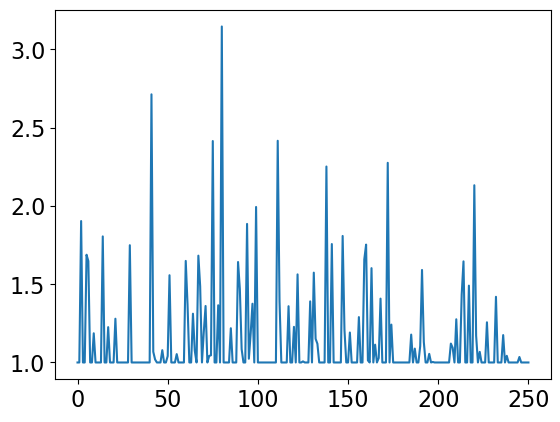

In [192]:
prior_realizations = np.zeros((30, t.shape[0]))
for ii in range(0, 30):
    for jj in range(0, len(t)):
        prior_realizations[ii, jj] = np.exp(log_prior(t))

plt.plot(prior_realizations[0,:])

In [193]:
from samplers import RWM

n_chains = int(1e4)
n_burnin = int(1e2)
n_thinning = 20


xi, logta, betas = RWM(d, n_chains, n_burnin, n_thinning, -np.ones(d), log_target)



Burn-in... 100 samples


Sample 500/10000

Sample 1000/10000

Sample 1500/10000

Sample 2000/10000

Sample 2500/10000

Sample 3000/10000

Sample 3500/10000

Sample 4000/10000

Sample 4500/10000

Sample 5000/10000

Sample 5500/10000

Sample 6000/10000

Sample 6500/10000

Sample 7000/10000

Sample 7500/10000

Sample 8000/10000

Sample 8500/10000

Sample 9000/10000

Sample 9500/10000

Sample 10000/10000

-Acceptance rate: 0.2241


In [194]:
prior_distribution = stats.multivariate_normal(mean=mu_u*np.ones(d), cov=sigma_2_u*np.eye(d))
prior = prior_distribution.rvs(n_chains).T

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

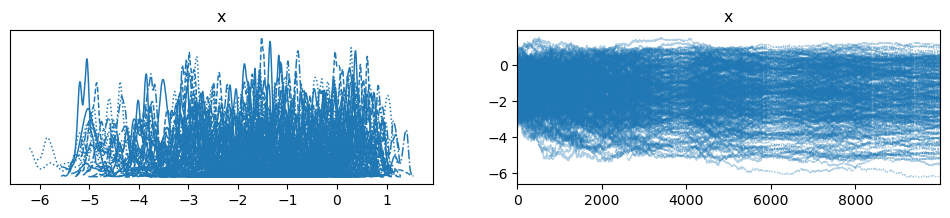

In [195]:
idata = az.convert_to_inference_data(xi)
az.plot_trace(idata,  compact=True)

Text(0.5, 1.0, 'Setup of the problem')

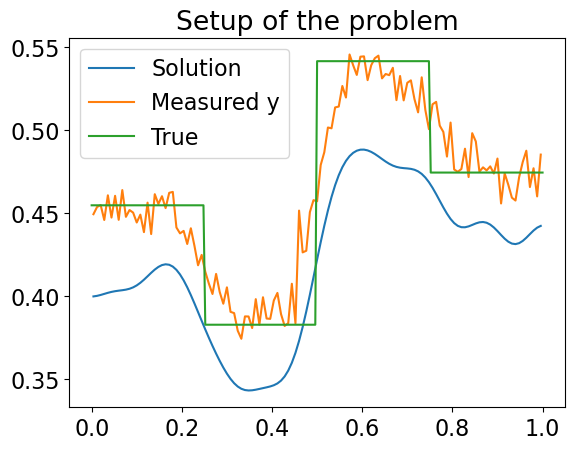

In [196]:
plt.plot(t_sens, A@np.exp(np.mean(xi, axis=1)))
#plt.plot(t_sens, A@np.exp(np.quantile(xi, 0.9, axis=1)))

plt.plot(t_sens, y_data)
plt.plot(t_true, np.exp(U(theta_true)))
plt.legend(['Solution', 'Measured y', 'True'])
plt.title('Setup of the problem')